In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pickle
import glob
import sys
import pandas as pd
import corner
import numpy as np
from astropy.table import Table
import math, scipy
from scipy.interpolate import interp1d
import pyccl as ccl
sys.path.append('../../pinocchio/')   
import pinocchio_mass_richness_relation as sim_mr_rel
import pinocchio_binning_scheme as binning_scheme
sys.path.append('../../modules/')
import class_richness_mass_relation as rm_relation
import cosmology
sys.path.append('../../modules/likelihood/')
import model_cluster_abundance as cl_count
import model_cluster_abundance
import model_stacked_cluster_mass
import forecast

# Define Count and lensing mass models

In [33]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [34]:
logMass_bin = binning_scheme.LogMass_bin
Z_bin = binning_scheme.Z_bin
Richness_bin = binning_scheme.Richness_bin

In [66]:
log10m0, z0 = sim_mr_rel.log10m0, sim_mr_rel.z0
proxy_mu0, proxy_muz, proxy_mulog10m =  sim_mr_rel.proxy_mu0, sim_mr_rel.proxy_muz, sim_mr_rel.proxy_mulog10m
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  sim_mr_rel.proxy_sigma0, sim_mr_rel.proxy_sigmaz, sim_mr_rel.proxy_sigmalog10m
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]
which_model = sim_mr_rel.which_model
sigma_wl_log10mass = sim_mr_rel.sigma_wl_log10mass
sigma_wl_tot_log10mass = np.sqrt(sim_mr_rel.sigma_wl_log10mass**2 + sim_mr_rel.sigma_wl_obs_log10mass**2)

In [59]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)
halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=massdef, mass_def_strict=True)
CosmologyObject = cosmology.Cosmology(hmf=hmd, bias_model=halobias_fct)

In [60]:
RM = rm_relation.Richness_mass_relation()
RM.select(which = which_model)

In [61]:
richness_grid = np.logspace(np.log10(20), np.log10(200), 310)
logm_grid = np.linspace(14.2, 16, 200)
z_grid = np.linspace(.2, 1, 201)

In [62]:
clc = model_cluster_abundance.ClusterAbundance(CosmologyObject = CosmologyObject, MoRObject = RM)
clm = model_stacked_cluster_mass.ClusterStackedMass(CosmologyObject = CosmologyObject, MoRObject = RM)

In [63]:
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
adds = {'add_purity' : False, 'add_completeness':False}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 
           'compute_completeness':False, 'compute_purity':False ,'compute_halo_bias':False,
          'compute_dNdzdlogMdOmega_log_slope': False}

In [64]:
def model_count(theta):
    Om, s8 = theta
    cosmox = ccl.Cosmology(Omega_c = Om - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = s8, n_s=0.96)
    params = {'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmox,}
    count_modelling_new = clc.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)
    integrand_count = clc.define_count_integrand(count_modelling_new, adds)
    Omega = 0.25*(4*np.pi)
    Nth = Omega * clc.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count, grids = grids)
    return Nth

In [65]:
Count_fiducial = model_count([0.30711, 0.8288])

In [48]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [ ]:
data_poisson = load(f'../../pinocchio/data/pinocchio_data_vector/data_vector_pinocchio_v2_mock_log_normal_poisson_scatter_sigma_lnMwl={sigma_wl_log10mass*np.log(10):.2f}.pkl')
data_poisson_log = load(f'../../pinocchio/data/pinocchio_data_vector/data_vector_pinocchio_v2_mock_log_normal_poisson_log_scatter_sigma_lnMwl={sigma_wl_log10mass*np.log(10):.2f}.pkl')

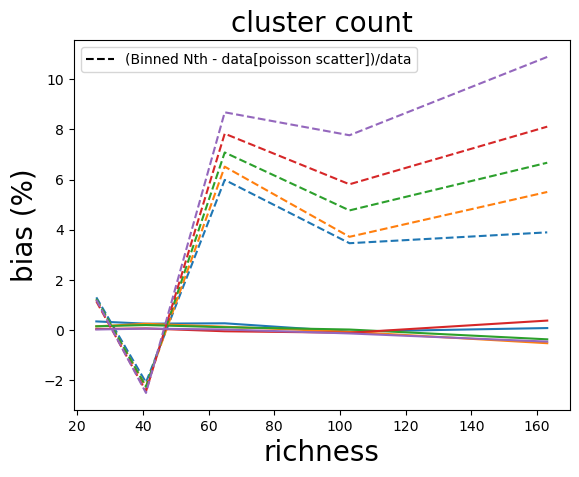

In [76]:
for i in range(5):
    plt.plot(np.mean(Richness_bin, axis=1), 100*(Count_fiducial[:,i] - data_poisson['mean_count_richness_redshift'][:,i])/Count_fiducial[:,i], '--', color = f'C{i}')
    plt.plot(np.mean(Richness_bin, axis=1), 100*(Count_fiducial[:,i] - data_poisson_log['mean_count_richness_redshift'][:,i])/Count_fiducial[:,i],  color = f'C{i}')

plt.plot([], [], '--k', label = '(Binned Nth - data[poisson scatter])/data')
plt.ylabel('bias (%)', fontsize=20,)
plt.title('cluster count', fontsize=20,)
plt.xlabel('richness', fontsize=20,)
plt.legend()

In [53]:
#def model_mass(theta, power):
#    Om, s8 = theta
#    cosmox = ccl.Cosmology(Omega_c = Om - 0.048254, Omega_b = 0.048254, 
#                              h = 0.6777, sigma8 = s8, n_s=0.96)
#    params = {'params_richness_mass_relation': theta_rm,
#              'CCL_cosmology': cosmox,}
#    count_modelling_new = clc.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)
#    integrand_count = clc.define_count_integrand(count_modelling_new, adds)
#    Omega = 0.25*(4*np.pi)
#    Nth = Omega * clc.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count, grids = grids)
#    NMth = Omega * clm.Cluster_dNd0mega_Mass_ProxyZ(bins, integrand_count = integrand_count,
#                                                         grids = grids, integrand = power)
#    if power == 'm**(1/3)':  
#        Mth = (NMth/Nth)**3
#    if power == 'm':  
#        Mth = (NMth/Nth)
#    return Mth

In [54]:
#Mass_fiducial_power = model_mass([0.30711, 0.8288], 'm**(1/3)')
#Mass_fiducial = model_mass([0.30711, 0.8288], 'm')

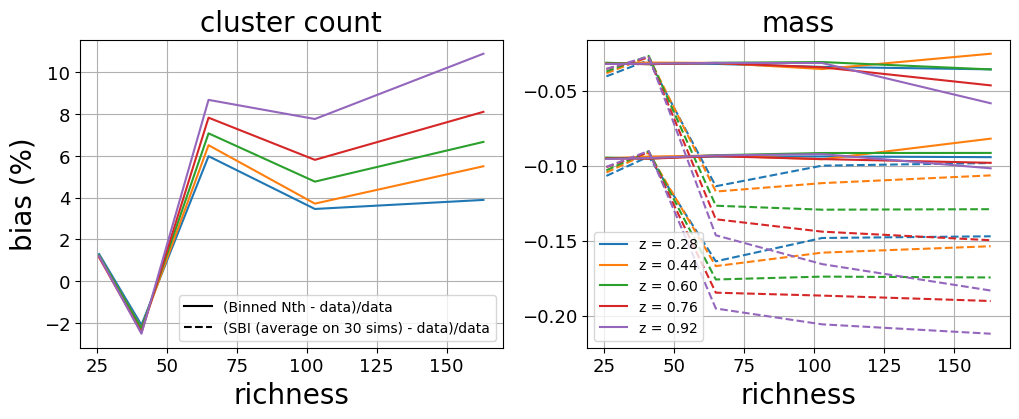

In [17]:
#fig, ax = plt.subplots(1, 2, figsize=(12, 4), )
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=None)
#for i in range(5):
#    ax[0].plot(np.mean(Richness_bin, axis=1), 100*(Count_fiducial[:,i] - data_poisson['mean_count_richness_redshift'][:,i])/Count_fiducial[:,i],  color = f'C{i}')
    #ax[0].plot(np.mean(Richness_bin, axis=1), 100*(Count_fiducial[:,i] - data_poisson_log['mean_count_richness_redshift'][:,i])/Count_fiducial[:,i],  color = f'C{i}')

#ax[0].plot([], [], '-k', label = '(Binned Nth - data)/data')
#ax[0].plot([], [], '--k', label = '(SBI (average on 30 sims) - data)/data')

#for i in range(5):
    #data poisson scatter
#    ax[1].errorbar(np.mean(Richness_bin, axis=1), 100*(np.log10(Mass_fiducial_power[:,i]) - np.log10(data_poisson['mean_mass_power_richness_redshift'][:,i]))/np.log10(Mass_fiducial[:,i]), 
#                   color = f'C{i}', fmt='--')
#    ax[1].errorbar(np.mean(Richness_bin, axis=1), 100*(np.log10(Mass_fiducial[:,i]) - np.log10(data_poisson['mean_mass_richness_redshift'][:,i]))/np.log10(Mass_fiducial[:,i]), 
#                   color = f'C{i}', fmt='--')
    #data poisson log
#    ax[1].errorbar(np.mean(Richness_bin, axis=1), 100*(np.log10(Mass_fiducial_power[:,i]) - np.log10(data_poisson_log['mean_mass_power_richness_redshift'][:,i]))/np.log10(Mass_fiducial[:,i]), 
#                   color = f'C{i}')
#    ax[1].errorbar(np.mean(Richness_bin, axis=1), 100*(np.log10(Mass_fiducial[:,i]) - np.log10(data_poisson_log['mean_mass_richness_redshift'][:,i]))/np.log10(Mass_fiducial[:,i]), 
#                   label = 'z = '+f'{np.mean(Z_bin[i]):.2f}', color = f'C{i}')
#for i in range(2):
#    ax[0].set_ylabel('bias (%)', fontsize=20,)
#    ax[0].set_title('cluster count', fontsize=20,)
#    ax[1].set_title(r'mass', fontsize=20,)
#    ax[i].set_xlabel('richness', fontsize=20,)
#for j in range(2):
#    ax[j].grid()
#    ax[j].legend()
#    ax[j].tick_params(axis='both', which = 'major', labelsize= 13)

#plt.tick_params(axis='both', which = 'major', labelsize= 13)